# Rapport TOTAL - COCHE Julien

Rapport à propos du challenge TOTAL.
Ce challenge avait pour but de déterminer la production de futurs puits à partir des données des puits déjà existants.

Pour cela, TOTAL a mis à disposition des données géographiques, géologiques et de production.

Ce rapport à pour but d'expliquer la démarche de résolution de ce challenge, et de présenter les résultats obtenus.

## Démarche

### Première itération.

Création du modèle de base.

Il contient ainsi :

- L'extraction des données.
- Un jeu de données simple et complet (colonnes incomplètes et dates éliminées).
- Un algorithme d'apprentissage simple (Logistic Regression).
- Mise en place de premiers indicateurs du modèle.
- Exportation des données au format CSV.

Ce modèle a pour but de créer une base qui va permettre d'évaluer les prochaines itérations du modèle.

Le dataset est "simple" et n'utilise pas la totalité des données.
Il est alors directement utilisé pour effectuer la prédiction à l'aide du regresseur.

### Seconde itération.

La seconde itération reprend le modèle précédent.

Des améliorations lui sont apportés, notamment :

- L'imputation de la moyenne dans les colonnes dont certaines valeurs sont manquantes.
- Utilisation d'un algorithme approprié au problème (DecisionTree)
- Séparation des données (cross validation) afin d'obtenir une répartition en train/dev/test sets.
- Mise en place d'une seconde série d'indicateurs du modèles.

Ce nouveau modèle doit permettre une première optimisation du problème.

Elle permet notamment d'utiliser une plus grande partie du jeu de données et d'employer un algorithme plus adapté au problème.
On sépare également le jeu de données d'entraînement en un train set et un dev set. Ce dernier permettra de juger de l'entraînement du modèle et de la précision de ses prédicitons.
Afin d'éviter un éventuel overfitting de l'arbre de décision, on utilise un algorithme de cross validation sur ces jeux de données.

### Troisième itération. 

Ce modèle apporte d'autres améliorations telles que :

- Utiliser un K-folds pour séparer les données d'entraînement et les données de validation.
- Retrait des artéfacts du jeu de données.
- L'intégration des données temporelles au jeu de données, en apportant une interprétation de celles-ci.
- L'utilisation d'un nouveau regresseur (GradientBoosting) et optimisation de celui-ci.

Ce modèle doit ainsi utiliser au mieux l'ensemble des données disponibles.
L'algorithme choisit est sensé fournir de très bons résultats dans le cadre de notre problème.

Il n'est cependant peut-être pas l'algorithme le plus adéquat, et cela mériterais une quatrième itération.
De même, les données peuvent peut-être être travaillées afin de fournir des composantes pertinentes qui aideraient à entrainer le modèle.

## 1 - Exploration du dataset.

Pour commencer, on importe les librairies qui seront utiles pour conduire l'analyse.

In [22]:
%matplotlib inline
import numpy as np # Librairie de calculs mathématiques.
import pandas as pd # Libriairie de manipulation de données.
import matplotlib.pyplot as plt # Librairie d'edition de graphiques.
import seaborn as sns # Librairie d'édition de graphiques avancés.


### Importation des données.

On importe alors les données issues du train set et du test set.

Pour cela, j'utilise la bibliothèque `pandas`. Elle permet d'employer une structure de donnée particulière : les **dataframes**.

Ces dataframes sont un tableau à double entrée. On peut donc définir un numéro de ligne ainsi qu'un nom de colonne.
Cela permet d'être plus clair dans la manipulation des données qu'avec un `numpy.array`.

De plus, `pandas` contient de très nombreuses méthodes qui facilitent la manipulation des données.

In [23]:
"""
Importation des données du train set.
Les options permettent de :
    - D'indiquer des séparateurs compréhensibles par la méthode (sep, decimal).
    - De nommer les colonnes du dataframe (names).
    - D'indiquer le type que l'on souhaite donner à ses données (dtype, parse_dates).
"""

names = ['API','Surf_X','Surf_Y','Date_Drilling','Date_Completion','Date_Production','Lateral_Length','Depth_TVD_PPLS','Erosion_PPLS','Pressure_PPLS','TOC_PPLS','Vcarb_PPLS','Vsand_PPLS','Vclay_PPLS','PR_PPLS','YM_PPLS','RHOB_PPLS','Res_PPLS','GR_PPLS','DT_PPLS','DTs_PPLS','Temperature','Temp_Anomaly','S3Tect_PPLS','S3_contrast_PPLS','Heat_Flow','Zone','Nbr_Stages','Frac_Gradient','Proppant_Designed','Proppant_in_Formation','Avg_Breakdown_Pressure','Avg_Treating_Pressure','Max_Treating_pressure','Min_Treating_Pressure','Avg_Rate_Slurry','Max_Rate_Slurry','Min_Rate_Slurry','ShutInPressure_Fil','ShutInPressure_Initial','ISIP','Shot_Density','Shot_Total','Proppant_per_ft','Stage_Spacing','GasCum360','OilCum360']

# Importation du train set dans la variable df_data.
df_data = pd.read_csv('./TrainSample.csv', 
                        header = None, 
                        sep = ';',
                        decimal = ',',
                        names = names,
                        skiprows = 1,
                        index_col=0,
                        parse_dates = ['Date_Drilling','Date_Completion','Date_Production'],
                        dtype = {col: np.float32 for col in names}
                       )

# Importation du test set dans la variable df_test.
df_test = pd.read_csv('./TestSample.csv',
                      header = None, 
                      sep = ';', 
                      decimal = ',', 
                      names = names,
                      skiprows = 1,
                      index_col=0,
                      parse_dates = ['Date_Drilling','Date_Completion','Date_Production'],
                      dtype = {col: np.float32 for col in names}
                     )


### Retrait des artéfacts.

TOTAL indique que les données sont nettoyées.
Cependant, lorsqu'on les analyse, on remarque que certaines composantes présentes des artéfacts qui peuvent nuire au modèle.

Comme les artéfacts sont peu nombreux, on les retire afin d'augmenter les performances qui modèle.

Pour cela :

- On affiche les composantes une par une.
- On identifie l'artéfact.
- On remplace sa valeur par un NaN.

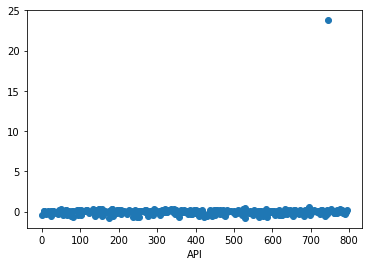

In [24]:
# Exemple d'artéfact dans la composante Frac_Gradient. 

df_data.Frac_Gradient.plot(style='o')


In [25]:
# Retrait de tous les artéfacts identifiés.

df_data.loc[746, 'Frac_Gradient'] = np.nan
df_data.loc[553, 'ISIP'] = np.nan
df_data.loc[681, 'Min_Rate_Slurry'] = np.nan
df_data.loc[424, 'Res_PPLS'] = np.nan
df_data.loc[456, 'ShutInPressure_Fil'] = np.nan
df_data.loc[723, 'Min_Treating_Pressure'] = np.nan
df_data.loc[205, 'Min_Treating_Pressure'] = np.nan


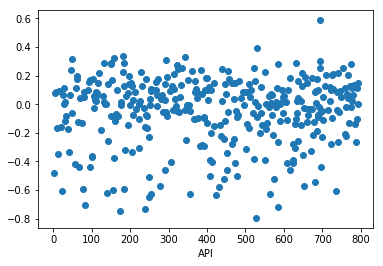

In [26]:
# On constate que l'artéfact a bien disparu.

df_data.Frac_Gradient.plot(style='o')


### 

In [27]:
##Définition des labels

y_gas = {'GasCum360' : df_data['GasCum360']}
y_oil = {'OilCum360' : df_data['OilCum360']}

df_target_gas = pd.DataFrame(y_gas)
df_target_oil = pd.DataFrame(y_oil)


### Création de nouvelles composantes.

Les données contiennent des dates.

Les algorithmes de machine learning ne savent pas utiliser les dates en tant que telles.
Il faut donc trouver un moyen de les intégrer.
Pour cela, je souhaite corréler la production de gas et d'huile avec les dates de forage, de mise en production et de ...

Les données temporelles sont un type particulier que je ne sais pas manipuler, je cherche encore le moyen d'extraire le nombre de jour entre 2 dates dans un dataframe.

J'aurais souhaité créer ainsi 4 nouvelles composantes qui seraient :

`Huile_prod = OilCum 360 / (Date_Production - Date_Drilling)`
`Gaz_prod = GasCum 360 / (Date_Production - Date_Drilling)`
`Huile_comp = OilCum 360 / (Date_Completion - Date_Drilling)`
`Gaz_comp = GasCum 360 / (Date_Completion - Date_Drilling)`

In [28]:
## Suppression des composantes pas utilisées

cols_date = ['Date_Drilling','Date_Completion','Date_Production', 'GasCum360', 'OilCum360']

df_data.drop(cols_date, 1, inplace=True)
df_test.drop(cols_date, 1, inplace=True)


### Imputation des valeurs manquantes.

Le jeu de données contient des valeurs manquantes.
Pour ne pas biaiser l'apprentissage, on complète ces valeurs manquantes par la moyenne de la composante.

Une autre méthode, aurait pu consister à compléter avec la valeur médiane, ou encore en effectuant une regression entre la valeur maximale et la valeur minimale.

In [29]:
## Imputation des valeurs manquantes

df_data.dropna()
df_test.dropna()
df_data = df_data.fillna(df_data.mean())
df_test = df_test.fillna(df_data.mean())


### Création du jeu de données d'entraînement et du jeu de données de validation.

Afin de valider nos résultats, on sépare les données d'entraînement fournies en 2 jeux de données distincts.

Le premier jeu de données (le jeu de données d'entraînement) permet l'apprentissage du modèle.
Le deuxième jeu de données (le jeu de données de validation) permet d'évaluer les performance du modèle sur des données proches de celles des données d'entraînements, mais qu'il n'a cependant jamais vu.

L'évalutation de l'erreur sur les données de validation est un bon indicateur de la performance du modèle.
Elle permet également de connaître la progression dont on dispose vis-à-vis du résultat sur les données d'entraînement.

On aurait pu également utiliser un K-folds pour séparer les données. Cependant, le jeu de données étant relativement petit, je n'étais pas certain des résultats qu'il pourrait apporter. A tester dans une prochaine itération.

In [30]:
## Split des données

from sklearn import cross_validation

X_train_gas, X_dev_gas, y_train_gas, y_dev_gas = cross_validation.train_test_split(df_data, df_target_gas, test_size=0.15, random_state=42)
X_train_oil, X_dev_oil, y_train_oil, y_dev_oil = cross_validation.train_test_split(df_data, df_target_oil, test_size=0.15, random_state=42)


## 2 - Choix du modèle.

Notre problème est un problème de prédiction de valeur issue d'un apprentissage supervisé.
On cherche à prédire des valeurs discrètes, on utilise donc une régression.
La précision du résultat est notre première préoccupation.

Lors de la première itération, le choix a été d'utiliser l'algorithme de Logisitic Regression : $$y = w*x +b\tag{1}$$

Lors de la seconde itération, j'ai choisi d'utiliser un Decision Tree, afin de privilégier la vitesse d'exécution des essais.

Enfin, pour la troisième itération, j'ai employé un Gradient Boosting, qui est un des algorithmes les plus adaptés au problème.

Un Neural Network peut éventuellement fournir de meilleurs résultats. Cependant, vu le peut d'exemples dont on dispose, l'amélioration ne m'a pas paru évidente.

### Choix du regresseur.

On importe le modèle choisi et on créé une instance.

Afin d'améliorer le résultat, on définit 2 modèles, avec des paramètres distincts. Il a ainsi un modèle pour chaque résultat souhaité.

L'algorithme de Gradient Boosting est la mise en commun des propriétés du Boosting et du Gradient Descent.

Le Boosting est une technique ensembliste qui consiste à agréger des modèles plus faibles (des Decision Tree) sur un échantillon d'apprentissage.
Les poids des individus (les modèles) sont corrigés au fur et à mesure, pour être pondérés selon leurs performances.

Le Gradient Descente (ou Descente de Gradient) est une méthode itérative qui permet d'approcher la solution d'un problème d'optimisation. A chaque itération, on détermine les paramètres du modèle choisit pour optimiser la fonction objectif.

Comme le Boosting est un algorithme qui agrége des Decision Tree, la structure de l'algorithme est proche de celle-ci.

Source : https://eric.univ-lyon2.fr/~ricco/cours/slides/gradient_boosting.pdf

In [31]:
## Définition du regresseur - GradientBoosting

from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor()


### Définition des paramètres

Lors des deux premières itérations, les algorithmes ne sont pas optimisés. Cependant, la troisième itération est l'occasion d'optimiser les paramètres.

Parmis les paramètres on retrouve :

- 'loss' (fonction coût) : la fonction coût utilisée pour la Descente de Gradient (Valeur Absolue/Moyenne au carré/Huber)
- 'n_estimators' (nombre d'estimateurs) : le nombre d'itérations pour l'étape de Boosting 
- 'learning_rate' (taux d'apprentissage) : taux auquel la contribution de chaque arbre décroit, à mettre en regard avec le nbr d'estimateurs.
- 'max_depth' (profondeur maximale) : profondeur maximale de chaque arbre créé
- 'criterion' (critère) : critère pour évaluer la qualité de la séparation des branches de chaque arbres (Mse/Mae/Friedman_mse)
- 'min_samples_split' (valeur minimale pour la séparation) : valeur minimale du critère pour la création d'une nouvelle branche.
- 'min_samples_leaf' (valeur minimale pour l'attribution des feuilles) : valeur minimale pour le positionnement sur une feuille
- 'alpha' (taux d'apprentissage) : taux d'apprentissage de la descente de gradient.

In [32]:
## Définition des paramètres pour le modèle dédié à la prédiction d'huile

param_grid_oil = [
    {
        'loss':['huber'],
        'n_estimators':[500],
        'learning_rate':[0.025],
        'max_depth':[4],
        'criterion':['friedman_mse'],
        'min_samples_split':[2],
        'min_samples_leaf':[2],
        'alpha':[0.909],
    }
]

In [33]:
## Définition des paramètres pour le modèle dédié à la prédiction de gaz.

param_grid_gas = [
    {
        'learning_rate':[0.05],
        'n_estimators': [700],
        'gamma':[0.0001],
        'min_child_weight':[2],
        'max_depth':[4],
        'max_delta_step':[4],
        'subsample':[0.9],
    }
]

### Optimisation des paramètres.

Afin de rechercher les meilleurs paramètres pour mon modèle, j'ai utilisé GridSearch.
Cet algorithme prend en entré une "grille" de valeurs qu'il teste, afin de retourner le résultat obtenu avec le meilleur jeu de paramètres.
Le nombre d'itérations est un hyperparamètre qu'il faut optimiser.

Une autre méthode, qui est davantage conseillée, est de faire une recherche aléatoire des paramètres (avec RandomizedSearch). Cette recherche permet d'obtenir plus rapidement et plus facilement des paramètres intéressants.

### Prédiction sur les données d'entraînement.

On instancie le regresseur avec les paramètres précédents à l'aide de GridSearch.
On entraine le modèle sur les données d'entraînement.
On effectue la regression sur ces mêmes données d'entraînement.

La première prédiction est effectuée sur les données d'entraînement afin d'obtenir un premier indicateur du comportement du modèle.


In [38]:
## Algorithme - prédiction du résultat pour l'huile sur le jeu de données d'entraînement.

from sklearn.model_selection import GridSearchCV

n_iter = 50

regr_oil = GridSearchCV(regr, param_grid=param_grid_oil, n_jobs=n_iter, cv=3)

regr_oil.fit(X_train_oil.values, y_train_oil.values.ravel())
y_predict_oil_train = regr_oil.predict(X_train_oil.values)

In [39]:
## Algorithme - prédiction du résultat pour le gaz sur le jeu de données d'entraînement.

regr_gas = GridSearchCV(regr, param_grid=param_grid_oil, n_jobs=n_iter, cv=3)

regr_gas.fit(X_train_gas.values, y_train_gas.values.ravel())
y_predict_gas_train = regr_gas.predict(X_train_gas.values)

## 3 - Evaluation du modèle.

L'évaluation de la prédicition du modèle est centrale. Elle permet de déterminer qu'elle stratégie adopter pour renforcer le modèle.

### Métriques sur le jeu de données d'entraînement.

La première série de métriques permet de déterminer l'erreur du modèle sur les données d'entraînement.
On peut ainsi déterminer si le modèle overfit ou non sur celles-ci.
L'overfitting du modèle est probable, car on utilise des DecisionTree.

In [41]:
## Metrics training oil

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

retour = 'Erreur Moyenne absolue : {}\n\
R2 : {}'.format(mean_absolute_error(y_train_oil, y_predict_oil_train),
                r2_score(y_train_oil, y_predict_oil_train),
               )
print(retour)

Erreur Moyenne absolue : 0.08249969220462915
R2 : 0.9130603928143104


In [44]:
## Metrics training gas 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

retour = 'Erreur Moyenne absolue : {}\n\
R2 : {}'.format(mean_absolute_error(y_train_gas, y_predict_gas_train),
                r2_score(y_train_gas, y_predict_gas_train),
               )
print(retour)

Erreur Moyenne absolue : 0.0651318116389813
R2 : 0.9770767441619204


### Conclusions sur les données d'entraînement.

On remarque que l'erreur est très faible.
Ce résultat est cohérent, car on entraine le modèle sur des données qu'il connaît déjà.

On remarque également que le modèle gaz est plus performant que le modèle huile (0,97 pour 0,91).
Visiblement, aucun modèle n'overfit vraiment les données d'entraînement.

### Prédiction sur les données d'évaluation.

On conserve les paramètres précédents et on effectue la prédiction sur les données d'évaluation.

In [45]:
## Algorithme - prédiction du résultat sur le jeu de données d'entraînement.

from sklearn.model_selection import GridSearchCV

n_iter = 50

regr_oil = GridSearchCV(regr, param_grid=param_grid_oil, n_jobs=n_iter, cv=3)

regr_oil.fit(X_train_oil.values, y_train_oil.values.ravel())
y_predict_oil_test = regr_oil.predict(X_dev_oil.values)

In [46]:
## Algorithme - prédiction du résultat sur le jeu de données d'entraînement.

regr_gas = GridSearchCV(regr, param_grid=param_grid_oil, n_jobs=n_iter, cv=3)

regr_gas.fit(X_train_gas.values, y_train_gas.values.ravel())
y_predict_gas_test = regr_gas.predict(X_dev_gas.values)

### Métriques sur le jeu de données d'évaluation.

Cette série de métriques permet de déterminer l'erreur sur les données d'évaluation.

On peut ainsi déterminer si le modèle overfit ou non sur celles-ci. L'overfitting du modèle est probable, car on utilise des DecisionTree.


In [47]:
## Metrics training gas 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

retour = 'Erreur Moyenne absolue : {}\n\
R2 : {}'.format(mean_absolute_error(y_dev_gas, y_predict_gas_test),
                r2_score(y_dev_gas, y_predict_gas_test),
               )
print(retour)

Erreur Moyenne absolue : 0.36003212388238565
R2 : 0.7175502173944199


In [50]:
## Metrics training oil

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

retour = 'Erreur Moyenne absolue : {}\n\
R2 : {}'.format(mean_absolute_error(y_dev_oil, y_predict_oil_test),
                r2_score(y_dev_oil, y_predict_oil_test))
print(retour)

Erreur Moyenne absolue : 0.26070684520915327
R2 : 0.8461449444906681


In [55]:
## Fit regression model test data

regr_gas.fit(df_data, df_target_gas.values.ravel())
regr_oil.fit(df_data, df_target_oil.values.ravel())

y_predictFin_gas = regr_gas.predict(df_test)
y_predictFin_oil = regr_oil.predict(df_test)

In [59]:
gascumpred = []
oilcumpred = []

gascumpred = [element for element in y_predictFin_gas]
oilcumpred = [element for element in y_predictFin_oil]

gascumpred_mean = mean_absolute_error(y_dev_gas, y_predict_gas_test)
oilcumpred_mean = mean_absolute_error(y_dev_oil, y_predict_oil_test)

GasCum360_inf = gascumpred - 2.2 * abs(gascumpred_mean)
GasCum360_sup = gascumpred + 2.2 * abs(gascumpred_mean)

OilCum360_inf = oilcumpred - 2.2 * abs(oilcumpred_mean)
OilCum360_sup = oilcumpred + 2.2 * abs(oilcumpred_mean)

GasCum360_inf.tolist
GasCum360_sup.tolist

OilCum360_inf.tolist
OilCum360_sup.tolist

<function ndarray.tolist>

In [64]:
y_predictFin_gas[:10]

array([-0.4936828 ,  0.3533605 ,  0.82005058,  0.56488723,  0.43469954,
       -0.86590474, -0.25056627, -1.0142927 ,  0.62498893,  0.71110048])

In [65]:
y_dev_gas.head(10)

,GasCum360
API,
517.0,-1.089723
694.0,-0.093905
557.0,2.583899
510.0,-0.020998
369.0,-0.796393
529.0,0.689649
709.0,-0.419608
184.0,0.456733
120.0,-0.398933


In [66]:
y_predictFin_oil[:15]

array([ 0.32977469, -0.83855603, -0.63878257, -0.73564221,  0.07862639,
       -0.42436647,  0.4805522 , -0.02421514, -0.87379398, -0.45306207,
        0.36790383,  3.40435004,  0.09048125, -0.8300038 ,  0.45155298])

In [67]:
y_dev_oil.head(15)

,OilCum360
API,
517.0,-0.846180
694.0,-0.573829
557.0,-0.451239
510.0,1.103248
369.0,1.567699
529.0,-0.661664
709.0,-0.319803
184.0,-0.738756
120.0,0.584454


## 5 - Exportation des données.

On exporte les données en format CSV en respectant les critères de l'énoncé.
On créé un Dataframe à partir des listes créées précédement pour établir la structure du rendue.
Puis on exporte à l'aide de la méthode .to_csv du dataframe.

In [ ]:
## Output

id_test = df_test.index.tolist()

output = pd.DataFrame({'API': id_test,
                       'GasCum360_INF': GasCum360_inf,
                       'GasCum360_SUP': GasCum360_sup,
                       'OilCum360_INF': OilCum360_inf,
                       'OilCum360_SUP': OilCum360_sup},
                      index=id_test
                     )

output.head()

output.to_csv('coche-julien-challenge-total.csv', index=False, sep= ';', decimal=',')

In [ ]:
print(output.head(5))